# Trả lời các câu hỏi


1) Phim có khả năng thu lời hay lỗ?  
2) Yếu tố nào ảnh hưởng doanh thu mạnh nhất?  
3) Khi nào là thời điểm tốt nhất để phát hành phim?  
4) Chỉ dựa vào thông số màu sắc (R, G, B, Brightness, Saturation), có thể đoán được đây là phim Hành động hay Lãng mạn không?
5) Sự kết hợp của các thể loại (ví dụ: "Action, Comedy") có tạo ra doanh thu tốt hơn một thể loại đơn lẻ không?  
6) Khán giả có xu hướng đánh giá cao và chi tiền nhiều hơn cho các bộ phim có thời lượng "vừa phải" (90-120 phút) so với các phim quá dài (>150 phút) hay không?

# Dữ liệu và mô hình sử dụng

### Dữ liệu


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy import stats



In [2]:
DATA_PATH = 'movies_dataset_enriched.csv'
df_raw = pd.read_csv(DATA_PATH)
print('Loaded:', DATA_PATH)
print('Shape:', df_raw.shape)
df_raw.head(3)

Loaded: movies_dataset_enriched.csv
Shape: (11187, 22)


,id,title,release_date,budget,revenue,runtime,rating,vote_count,popularity,genres,...,director,cast,keywords,original_language,collection,poster_brightness,poster_saturation,poster_dom_r,poster_dom_g,poster_dom_b
0,8358,Cast Away,2000-12-22,90000000,429632142,143,7.660,11912,7.0546,"Adventure, Drama",...,Robert Zemeckis,"Tom Hanks, Helen Hunt, Chris Noth, Paul Sanche...","exotic island, suicide attempt, volleyball, su...",en,NaN,104.25,58.37,104.0,86.0,80.0
1,98,Gladiator,2000-05-04,103000000,465516248,155,8.220,20234,16.4449,"Action, Drama, Adventure",...,Ridley Scott,"Russell Crowe, Joaquin Phoenix, Connie Nielsen...","gladiator, rome, italy, arena, senate, roman e...",en,Gladiator Collection,129.02,102.34,129.0,102.0,73.0
2,8871,How the Grinch Stole Christmas,2000-11-17,123000000,345800000,104,6.775,7940,25.2338,"Family, Comedy, Fantasy",...,Ron Howard,"Jim Carrey, Taylor Momsen, Jeffrey Tambor, Chr...","new love, based on novel or book, holiday, chr...",en,NaN,157.19,130.06,96.0,119.0,136.0


### Quá trình tiền xử lý

In [3]:
def _parse_list_safe(x):
    if pd.isna(x) or str(x).strip() == '':
        return []
    if isinstance(x, str):
        return [i.strip() for i in x.split(',')]
    return []

def _parse_collection_to_list(x):
    if pd.isna(x) or str(x).strip() == '':
        return []
    return [str(x).strip()]

def time_based_target_encoding(df_sorted, list_col_name, target_col, alpha=10):
    """
    Tính encoding dựa trên lịch sử quá khứ.
    - df_raw: DataFrame ĐÃ ĐƯỢC SORT theo thời gian.
    - list_col_name: Cột chứa list (vd: cast, keywords).
    - target_col: Cột mục tiêu (log_revenue).
    - alpha: Hệ số làm mượt (smoothing factor).
    """
    global_mean = df_sorted[target_col].mean()

    # Dictionary lưu lịch sử: {'Tom Cruise': {'sum': 500, 'count': 5}}
    history = {}

    feature_values = []

    # Duyệt tuần tự theo thời gian
    for idx, row in df_sorted.iterrows():
        current_items = row[list_col_name]
        target_val = row[target_col]

        # DỰ ĐOÁN (Dựa trên quá khứ)
        stats = []
        for item in current_items:
            if item in history:
                rec = history[item]
                # Smoothed Mean: (Tổng doanh thu quá khứ + alpha * Global) / (Số phim quá khứ + alpha)
                mean_val = (rec['sum'] + alpha * global_mean) / (rec['count'] + alpha)
                stats.append(mean_val)
            else:
                stats.append(global_mean)

        # Tổng hợp điểm số cho bộ phim
        if stats:
            # Kết hợp: 70% sức mạnh ngôi sao lớn nhất (Max) + 30% sức mạnh tập thể (Mean)
            score = 0.7 * np.max(stats) + 0.3 * np.mean(stats)
        else:
            score = global_mean

        feature_values.append(score)

        #  (Cập nhật vào lịch sử cho phim sau dùng)
        if target_val > 0:
            for item in current_items:
                if item not in history:
                    history[item] = {'sum': 0.0, 'count': 0.0}
                history[item]['sum'] += target_val
                history[item]['count'] += 1.0
    return feature_values

def prepare_features(df_input):
    df = df_input.copy()

    # keep raw columns for business questions (NOT for model training)
    df['budget_raw'] = pd.to_numeric(df.get('budget'), errors='coerce')
    df['revenue_raw'] = pd.to_numeric(df.get('revenue'), errors='coerce')

    # target: log1p(revenue)
    df['revenue'] = np.log1p(df['revenue_raw'].clip(lower=0))

    # release date features
    df['release_date'] = pd.to_datetime(df.get('release_date'), errors='coerce')
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_dayofweek'] = df['release_date'].dt.dayofweek
    df['release_quarter'] = df['release_date'].dt.quarter
    df['is_weekend'] = df['release_dayofweek'].apply(lambda x: 1 if pd.notna(x) and x >= 5 else 0)
    df['is_blockbuster_season'] = df['release_month'].apply(lambda x: 1 if pd.notna(x) and x in [5, 6, 7, 11, 12] else 0)

    # list-like columns
    list_cols = ['genres', 'cast', 'production_companies', 'production_countries', 'director', 'keywords']
    for col in list_cols:
        if col in df.columns:
            df[col] = df[col].apply(_parse_list_safe)
        else:
            df[col] = [[] for _ in range(len(df))]

    # franchise
    if 'collection' in df.columns:
        df['is_franchise'] = df['collection'].notna().astype(int)
    else:
        df['is_franchise'] = 0

    # runtime
    if 'runtime' in df.columns:
        df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
        df['runtime'] = df['runtime'].replace(0, np.nan)
        df['runtime'] = df['runtime'].fillna(df['runtime'].median())
    else:
        df['runtime'] = np.nan

    # budget
    df['budget_raw'] = df['budget_raw'].replace(0, np.nan)
    df['temp_genre'] = df['genres'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

    budget_medians = df.groupby(['release_year', 'temp_genre'])['budget_raw'].transform('median')
    df['budget_raw'] = df['budget_raw'].fillna(budget_medians).fillna(df['budget_raw'].median())
    df['budget'] = np.log1p(df['budget_raw'].clip(lower=0))

    # poster features (if exist)
    poster_cols = ['poster_brightness', 'poster_saturation', 'poster_dom_r', 'poster_dom_g', 'poster_dom_b']
    if all(c in df.columns for c in poster_cols):
        for c in poster_cols:
            df[c] = pd.to_numeric(df[c], errors='coerce')
            df[c] = df[c].fillna(df[c].median())
        df['poster_warmth'] = df['poster_dom_r'] - df['poster_dom_b']
        total_intensity = (df['poster_dom_r'] + df['poster_dom_g'] + df['poster_dom_b']).replace(0, 1)
        df['poster_red_ratio'] = df['poster_dom_r'] / total_intensity
        df['poster_green_ratio'] = df['poster_dom_g'] / total_intensity
        df['poster_blue_ratio'] = df['poster_dom_b'] / total_intensity
        df['poster_vividness'] = (df['poster_saturation'] / 255.0) * (df['poster_brightness'] / 255.0)

    # sort by time and compute time-based encodings
    df = df.sort_values('release_date').reset_index(drop=True)

    # 1. Cast
    df['cast_score'] = time_based_target_encoding(df, 'cast', 'revenue', alpha=10)

    # 2. Director
    df['director_score'] = time_based_target_encoding(df, 'director', 'revenue', alpha=5)

    # 3. Keywords
    df['keyword_score'] = time_based_target_encoding(df, 'keywords', 'revenue', alpha=20)

    # 4. Genres
    df['genre_score'] = time_based_target_encoding(df, 'genres', 'revenue', alpha=50)

    # 5. Production Companies
    df['production_company_score'] = time_based_target_encoding(df, 'production_companies', 'revenue', alpha=10)

    # 6. Production Countries
    df['country_score'] = time_based_target_encoding(df, 'production_countries', 'revenue', alpha=20)

    # 7. collection
    df['collection_list'] = df.get('collection', pd.Series([np.nan] * len(df))).apply(_parse_collection_to_list)
    df['collection_score'] = time_based_target_encoding(df, 'collection_list', 'revenue', alpha=1)

    # multi-hot for genres
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(df['genres'])
    genres_df = pd.DataFrame(
        genres_encoded,
        columns=[f"genre_{c.replace(' ', '_')}" for c in mlb.classes_],
        index=df.index,
    )
    df = df.join(genres_df)

    # drop text/ids
    cols_to_drop = [
        'id','title','release_date','genres','cast','production_companies',
        'production_countries','keywords','director','original_language','rating',
        'vote_count','popularity','collection_list','collection','temp_genre'
    ]
    cols_to_drop = [c for c in cols_to_drop if c in df.columns]

    df_model = df.drop(columns=cols_to_drop)
    y = df_model['revenue']

    # IMPORTANT: remove target leakage columns from features
    X = df_model.drop(columns=['revenue'])
    leakage_cols = [c for c in ['revenue_raw', 'budget_raw'] if c in X.columns]
    if leakage_cols:
        X = X.drop(columns=leakage_cols)
    return df, X, y

df_full, X, y = prepare_features(df_raw)
print('Leakage columns present in X:', sorted(set(['revenue_raw','budget_raw']) & set(X.columns)))
print('X shape:', X.shape)
print('y shape:', y.shape)
X.head(3)

Leakage columns present in X: []
X shape: (11187, 45)
y shape: (11187,)


,budget,runtime,poster_brightness,poster_saturation,poster_dom_r,poster_dom_g,poster_dom_b,release_year,release_month,release_dayofweek,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western
0,18.197537,74.0,123.87,174.74,104.0,66.0,76.0,2000,1,5,...,0,0,1,0,0,0,0,0,0,0
1,16.300417,105.0,120.89,115.73,118.0,76.0,63.0,2000,1,4,...,0,0,0,0,1,0,0,0,0,0
2,16.213406,98.0,176.13,131.26,130.0,119.0,129.0,2000,1,2,...,0,0,0,0,0,0,0,0,0,0


### Huấn luyện mô hình (sử dụng mô hình XGBoost)

Dùng 80% dữ liệu theo thời gian làm train, 20% sau cùng làm test để đánh giá tổng quát.

In [4]:
train_size = int(len(df_full) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Data ready for XGBoost!")

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,      # Số lượng cây
    learning_rate=0.05,     # Tốc độ học
    max_depth=2,            # Độ sâu của cây (tránh overfitting)
    subsample=0.8,          # Dùng 80% dữ liệu mỗi lần để tránh overfit
    colsample_bytree=0.8,   # Dùng 80% feature mỗi lần
    n_jobs=-1,              # Dùng hết CPU
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE (Log Scale): {rmse}")
print(f"R2: {r2}")

Data ready for XGBoost!
RMSE (Log Scale): 1.9453973322910492
R2: 0.504496442284105


## 1) Phim có khả năng thu lời hay lỗ?
Cho phép nhập thông tin của một phim mới và dự đoán doanh thu dựa trên mô hình đã train.

Ghi chú:
- Các cột như `cast_score`, `director_score`, ... được tính từ thống kê lịch sử trong tập dữ liệu hiện có (xấp xỉ).
- Đầu ra mô hình là `log1p(revenue)` nên sẽ chuyển về `revenue = expm1(pred)` để dễ đọc.

In [5]:
def _as_list(x):
    """Normalize list inputs: accept list[str] or comma-separated string or None."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, list):
        return [str(i).strip() for i in x if str(i).strip() != '']
    if isinstance(x, str):
        return [i.strip() for i in x.split(',') if i.strip() != '']
    return [str(x).strip()]

def _build_item_stats(df_hist, list_col, target_col='revenue'):
    """Build {item: (sum_target, count)} over full historical dataframe."""
    stats = {}
    for items, target_val in zip(df_hist[list_col], df_hist[target_col]):
        if items is None:
            continue
        for item in items:
            if not item:
                continue
            if item not in stats:
                stats[item] = [0.0, 0]
            stats[item][0] += float(target_val)
            stats[item][1] += 1
    return stats, float(df_hist[target_col].mean())

def _score_items(items, stats, global_mean, alpha=10):
    """Smoothed score for a list of entities; mirrors training encoding aggregation."""
    if not items:
        return float(global_mean)
    means = []
    for item in items:
        rec = stats.get(item)
        if rec is None:
            means.append(float(global_mean))
        else:
            s, c = rec
            means.append((s + alpha * global_mean) / (c + alpha))
    return 0.7 * float(np.max(means)) + 0.3 * float(np.mean(means))

# Precompute stats for encoding-like features (using all available history in df_full)
_STATS = {}
for col, a in [
    ('cast', 10),
    ('director', 5),
    ('keywords', 20),
    ('genres', 50),
    ('production_companies', 10),
    ('production_countries', 20),
    ('collection_list', 1),
    ]:
    if col in df_full.columns:
        stats, gmean = _build_item_stats(df_full, col, target_col='revenue')
        _STATS[col] = {'stats': stats, 'global_mean': gmean, 'alpha': a}

# Poster medians to fill missing inputs (if these columns exist)
_POSTER_COLS = ['poster_brightness','poster_saturation','poster_dom_r','poster_dom_g','poster_dom_b']
_poster_medians = {}
for c in _POSTER_COLS:
    if c in df_full.columns:
        _poster_medians[c] = float(pd.to_numeric(df_full[c], errors='coerce').median())

def build_feature_row_for_movie(movie, X_columns, X_reference=None):
    """
    Convert a movie dict into a single-row DataFrame aligned with training X columns.

    movie keys (suggested):
    - title (optional)
    - release_date (YYYY-MM-DD)
    - budget (number, USD)
    - runtime (minutes)
    - genres, cast, production_companies, production_countries, director, keywords (list or comma-string)
    - collection (string or None)
    - poster_brightness, poster_saturation, poster_dom_r, poster_dom_g, poster_dom_b (optional)
    """
    if X_reference is None:
        X_reference = X
    base = X_reference.median(numeric_only=True)
    row = base.reindex(X_columns).copy()  # ensure all columns exist
    row = row.fillna(0)

    # parse date
    release_date = pd.to_datetime(movie.get('release_date'), errors='coerce')
    if pd.isna(release_date):
        raise ValueError("release_date is required (e.g. '2025-12-30')")

    # release features
    if 'release_year' in row.index:
        row['release_year'] = int(release_date.year)
    if 'release_month' in row.index:
        row['release_month'] = int(release_date.month)
    if 'release_dayofweek' in row.index:
        row['release_dayofweek'] = int(release_date.dayofweek)
    if 'release_quarter' in row.index:
        row['release_quarter'] = int(release_date.quarter)
    if 'is_weekend' in row.index:
        row['is_weekend'] = 1 if release_date.dayofweek >= 5 else 0
    if 'is_blockbuster_season' in row.index:
        row['is_blockbuster_season'] = 1 if release_date.month in [5, 6, 7, 11, 12] else 0

    # numeric inputs
    budget = movie.get('budget', None)
    if budget is not None and not (isinstance(budget, float) and np.isnan(budget)):
        if 'budget' in row.index:
            row['budget'] = float(np.log1p(max(float(budget), 0.0)))
    runtime = movie.get('runtime', None)
    if runtime is not None and not (isinstance(runtime, float) and np.isnan(runtime)):
        if 'runtime' in row.index:
            row['runtime'] = float(runtime)

    # franchise / collection
    collection = movie.get('collection', None)
    if 'is_franchise' in row.index:
        row['is_franchise'] = 1 if collection is not None and str(collection).strip() != '' else 0

    # poster (optional + derived)
    for c in _POSTER_COLS:
        if c in row.index:
            val = movie.get(c, None)
            if val is None or (isinstance(val, float) and np.isnan(val)):
                if c in _poster_medians:
                    row[c] = _poster_medians[c]
            else:
                row[c] = float(val)

    if all(c in row.index for c in _POSTER_COLS):
        if 'poster_warmth' in row.index:
            row['poster_warmth'] = float(row['poster_dom_r'] - row['poster_dom_b'])
        total_intensity = float(row['poster_dom_r'] + row['poster_dom_g'] + row['poster_dom_b'])
        if total_intensity == 0:
            total_intensity = 1.0
        if 'poster_red_ratio' in row.index:
            row['poster_red_ratio'] = float(row['poster_dom_r'] / total_intensity)
        if 'poster_green_ratio' in row.index:
            row['poster_green_ratio'] = float(row['poster_dom_g'] / total_intensity)
        if 'poster_blue_ratio' in row.index:
            row['poster_blue_ratio'] = float(row['poster_dom_b'] / total_intensity)
        if 'poster_vividness' in row.index:
            row['poster_vividness'] = float((row['poster_saturation'] / 255.0) * (row['poster_brightness'] / 255.0))

    # list inputs
    genres = _as_list(movie.get('genres'))
    cast = _as_list(movie.get('cast'))
    production_companies = _as_list(movie.get('production_companies'))
    production_countries = _as_list(movie.get('production_countries'))
    director = _as_list(movie.get('director'))
    keywords = _as_list(movie.get('keywords'))
    collection_list = _as_list(collection)
    if isinstance(collection, str) and ',' in collection:
        # if user put commas, keep the entire string as 1 collection name by default
        collection_list = [collection.strip()]
    elif collection is None or str(collection).strip() == '':
        collection_list = []
    else:
        collection_list = [str(collection).strip()]

    # scores (target-encoding style)
    def _apply_score(col_name, items, out_feature_name):
        if out_feature_name not in row.index:
            return
        meta = _STATS.get(col_name)
        if meta is None:
            return
        row[out_feature_name] = _score_items(items, meta['stats'], meta['global_mean'], alpha=meta['alpha'])

    _apply_score('cast', cast, 'cast_score')
    _apply_score('director', director, 'director_score')
    _apply_score('keywords', keywords, 'keyword_score')
    _apply_score('genres', genres, 'genre_score')
    _apply_score('production_companies', production_companies, 'production_company_score')
    _apply_score('production_countries', production_countries, 'country_score')
    _apply_score('collection_list', collection_list, 'collection_score')

    # genre multi-hot columns (match training X columns: genre_<name_with_underscores>)
    for g in genres:
        col = f"genre_{g.replace(' ', '_')}"
        if col in row.index:
            row[col] = 1.0

    # final shape
    X_row = pd.DataFrame([row.values], columns=row.index)
    return X_row[X_columns]

def predict_movie(movie, model, X_columns, X_reference=None):
    X_row = build_feature_row_for_movie(movie, X_columns=X_columns, X_reference=X_reference)
    pred_log = float(model.predict(X_row)[0])
    pred_rev = float(np.expm1(pred_log))
    out = {
        'pred_log1p_revenue': pred_log,
        'pred_revenue': pred_rev,
    }
    # optional profit estimate if user provided budget
    if movie.get('budget') is not None:
        out['budget'] = float(movie['budget'])
        out['pred_profit'] = float(pred_rev - float(movie['budget']))
        out['pred_is_profit'] = bool(pred_rev > float(movie['budget']))
    return out

In [6]:
# ==== NHẬP DỮ LIỆU PHIM CẦN DỰ ĐOÁN (bạn sửa các giá trị bên dưới) ====
movie_input = {
    'title': 'My Movie',
    'release_date': '2026-07-15',  # YYYY-MM-DD
    'budget': 80_000_000,          # USD
    'runtime': 120,                # minutes
    'genres': 'Action, Adventure',
    'cast': 'Tom Hanks, Scarlett Johansson',
    'director': 'Christopher Nolan',
    'production_companies': 'Warner Bros. Pictures',
    'production_countries': 'United States of America',
    'keywords': 'superhero, space, war',
    'collection': '',              # hoặc tên collection nếu thuộc franchise
    # Poster features (optional). Nếu bỏ trống, sẽ dùng median từ dataset
    # 'poster_brightness': 120,
    # 'poster_saturation': 100,
    # 'poster_dom_r': 110,
    # 'poster_dom_g': 90,
    # 'poster_dom_b': 70,
}

pred_out = predict_movie(movie_input, model=model, X_columns=list(X.columns), X_reference=X)
print('--- Prediction ---')
print('Title:', movie_input.get('title'))
print('Predicted log1p(revenue):', pred_out['pred_log1p_revenue'])
print('Predicted revenue (USD):', f"${pred_out['pred_revenue']:,.0f}")
if 'pred_is_profit' in pred_out:
    print('Budget (USD):', f"${pred_out['budget']:,.0f}")
    print('Predicted profit (USD):', f"${pred_out['pred_profit']:,.0f}")
    print('Predicted is profit?:', pred_out['pred_is_profit'])

--- Prediction ---
Title: My Movie
Predicted log1p(revenue): 18.84296226501465
Predicted revenue (USD): $152,543,790
Budget (USD): $80,000,000
Predicted profit (USD): $72,543,790
Predicted is profit?: True


# 2) Yếu tố nào ảnh hưởng doanh thu mạnh nhất?
Dùng **feature importance** từ XGBoost

,importance
production_company_score,0.277535
is_franchise,0.103502
budget,0.090176
director_score,0.075303
runtime,0.031933
genre_Drama,0.031817
keyword_score,0.029235
genre_Comedy,0.028997
cast_score,0.026207
is_weekend,0.021014


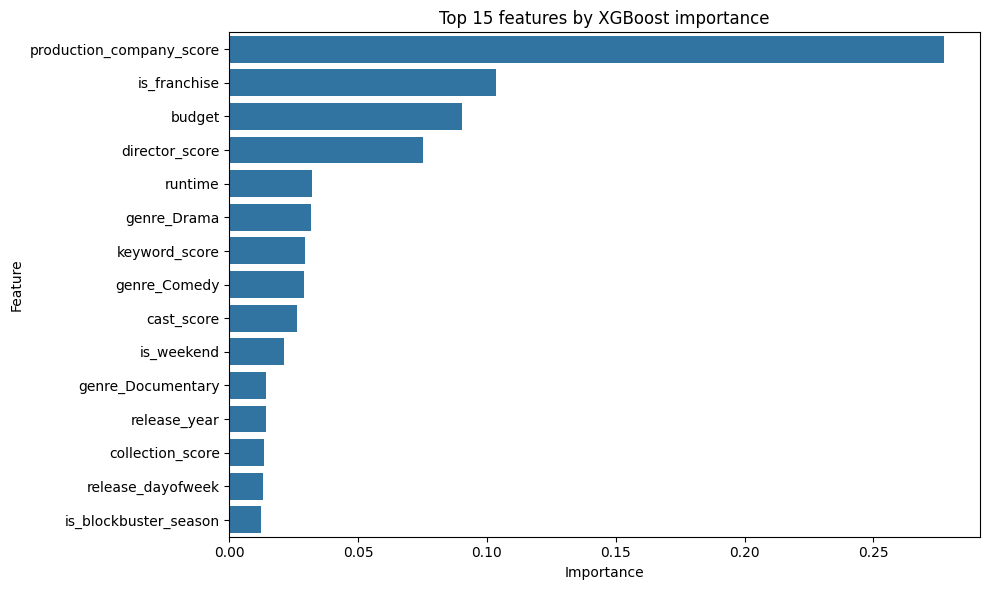

In [7]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_k = 15
display(importances.head(top_k).to_frame('importance'))

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(top_k).values, y=importances.head(top_k).index)
plt.title(f'Top {top_k} features by XGBoost importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Nhận xét về kết quả**
- Trong top features, `production_company_score` nổi bật nhất, gợi ý rằng “độ mạnh” của hãng sản xuất (theo lịch sử doanh thu trong dữ liệu) là một tín hiệu rất quan trọng đối với doanh thu.
- `is_franchise` đứng cao cho thấy phim thuộc series/franchise thường có lợi thế doanh thu (tận dụng tệp khán giả sẵn có).
- `budget` nằm trong nhóm đầu phản ánh xu hướng phổ biến: phim đầu tư lớn thường đi kèm tiềm năng doanh thu cao (nhưng không đồng nghĩa *luôn* lời vì chi phí cũng tăng).
- Các biến như `director_score`, `cast_score`, `keyword_score`, `collection_score` cho thấy **thành phần sáng tạo/nhận diện thương hiệu** (đạo diễn, dàn diễn viên, chủ đề, franchise) cũng góp phần đáng kể.
- Lưu ý quan trọng: feature importance của XGBoost **không phải quan hệ nhân-quả**. Một feature quan trọng có thể chỉ là đại diện cho nhiều yếu tố khác (tương quan/đồng biến), và mức importance cũng phụ thuộc vào cách mã hoá dữ liệu + tập dữ liệu hiện có.

# 3) Khi nào là thời điểm tốt nhất để phát hành phim?
Trả lời theo 2 cách:
- **Thống kê lịch sử**: doanh thu theo tháng / quý / thứ trong tuần.
- **Mô phỏng bằng mô hình**: giữ nguyên các feature khác (median), thay đổi tháng để xem tháng nào dự đoán cao nhất.



,count,median,mean
release_month,,,
1,800,6134562.0,3.138834e+07
2,856,7900134.0,4.724697e+07
3,909,7875862.0,4.926160e+07
4,846,6744544.5,5.159663e+07
5,750,4704623.0,7.847416e+07
6,763,5639730.0,9.064110e+07
7,820,10927813.0,8.049623e+07
8,984,7148464.5,3.514734e+07
9,1331,4717597.0,3.017630e+07


,count,median,mean
release_dayofweek,,,
0,329,4500000.0,5.474086e+07
1,510,9820052.5,1.074540e+08
2,2188,13501816.5,1.018721e+08
3,2799,6535535.0,4.637766e+07
4,4386,4907757.5,3.134122e+07
5,678,6762904.5,4.033578e+07
6,297,2360281.0,4.119399e+07


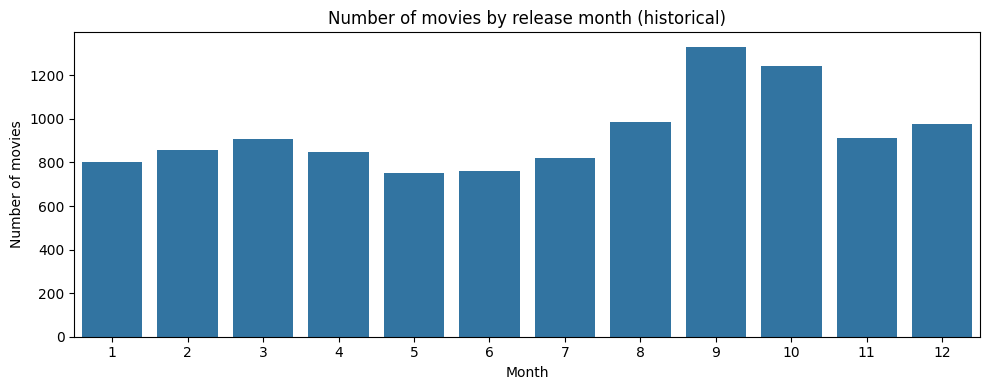

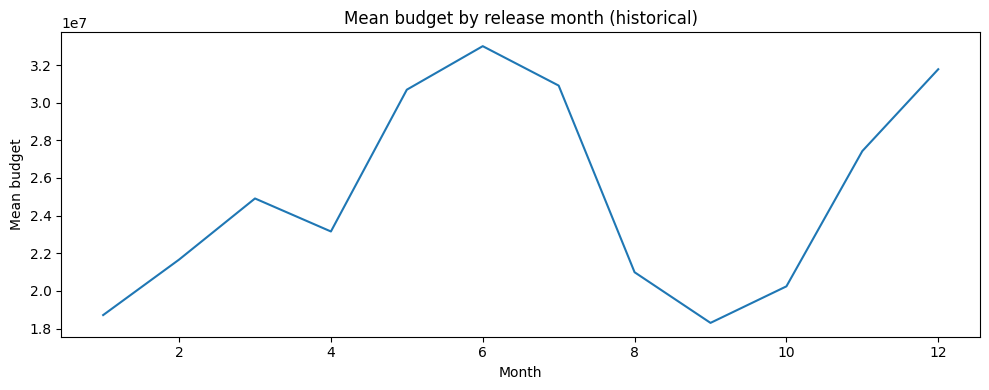

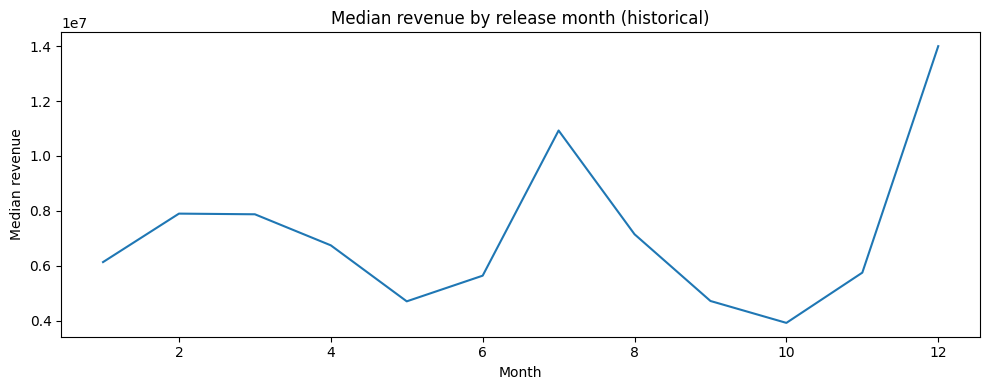

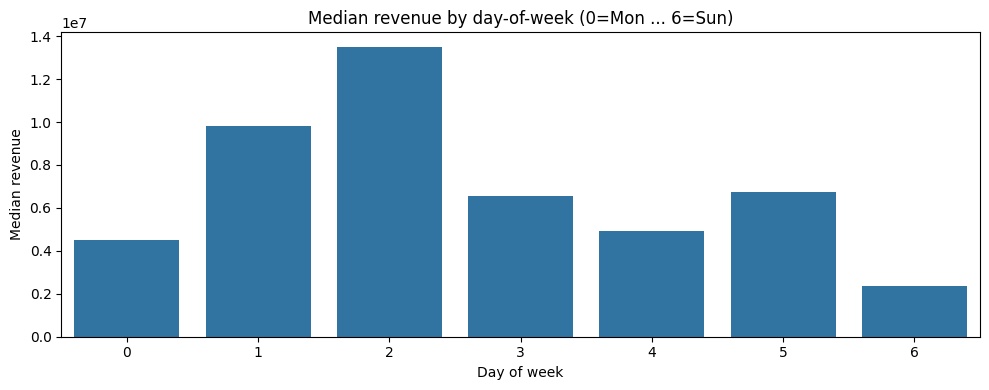

In [8]:
df_time = df_full.dropna(subset=['revenue_raw']).copy()
df_time['release_month'] = pd.to_numeric(df_time['release_month'], errors='coerce')
df_time['release_dayofweek'] = pd.to_numeric(df_time['release_dayofweek'], errors='coerce')

month_stats = df_time.groupby('release_month')['revenue_raw'].agg(['count', 'median', 'mean']).sort_index()
dow_stats = df_time.groupby('release_dayofweek')['revenue_raw'].agg(['count', 'median', 'mean']).sort_index()

display(month_stats)
display(dow_stats)

plt.figure(figsize=(10, 4))
sns.barplot(x=month_stats.index, y=month_stats['count'])
plt.title('Number of movies by release month (historical)')
plt.xlabel('Month')
plt.ylabel('Number of movies')
plt.tight_layout()
plt.show()

# Mean budget by month (historical)
if 'budget_raw' in df_time.columns:
    budget_mean = df_time.dropna(subset=['budget_raw']).groupby('release_month')['budget_raw'].mean().sort_index()
    plt.figure(figsize=(10, 4))
    sns.lineplot(x=budget_mean.index, y=budget_mean.values)
    plt.title('Mean budget by release month (historical)')
    plt.xlabel('Month')
    plt.ylabel('Mean budget')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 4))
sns.lineplot(x=month_stats.index, y=month_stats['median'])
plt.title('Median revenue by release month (historical)')
plt.xlabel('Month')
plt.ylabel('Median revenue')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(x=dow_stats.index, y=dow_stats['median'])
plt.title('Median revenue by day-of-week (0=Mon ... 6=Sun)')
plt.xlabel('Day of week')
plt.ylabel('Median revenue')
plt.tight_layout()
plt.show()

Best month by model simulation (typical movie): 1


,month,predicted_revenue
0,1,2.677279e+06
1,2,2.677279e+06
11,12,2.615145e+06
6,7,2.532642e+06
2,3,2.527936e+06


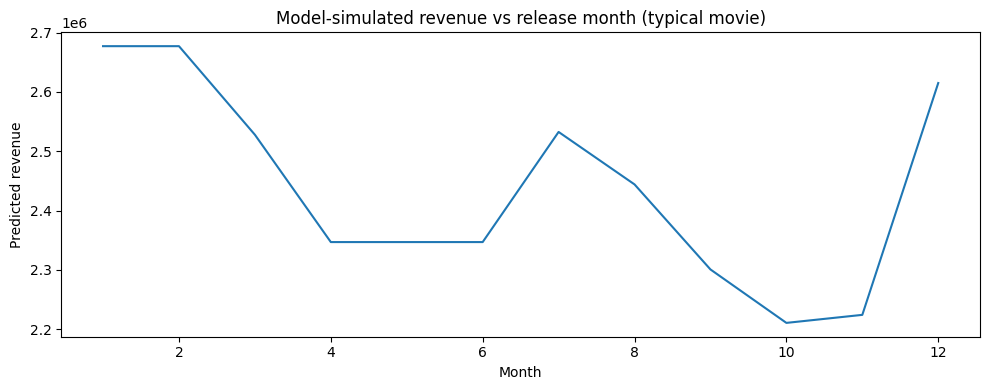

In [9]:
# Model-based simulation: vary month while keeping other features fixed at median
base = X.median(numeric_only=True).to_frame().T

def simulate_by_month(base_row):
    rows = []
    for m in range(1, 13):
        r = base_row.copy()
        if 'release_month' in r.columns:
            r.loc[r.index[0], 'release_month'] = m
        if 'release_quarter' in r.columns:
            r.loc[r.index[0], 'release_quarter'] = int((m - 1) / 3) + 1
        # keep a typical weekday release (Friday)
        if 'release_dayofweek' in r.columns:
            r.loc[r.index[0], 'release_dayofweek'] = 4
        if 'is_weekend' in r.columns:
            r.loc[r.index[0], 'is_weekend'] = 0
        if 'is_blockbuster_season' in r.columns:
            r.loc[r.index[0], 'is_blockbuster_season'] = 1 if m in [5, 6, 7, 11, 12] else 0

        yhat = float(model.predict(r)[0])
        rows.append({'month': m, 'predicted_revenue': float(np.expm1(yhat))})
    return pd.DataFrame(rows)

sim_month = simulate_by_month(base)
best_month = int(sim_month.sort_values('predicted_revenue', ascending=False).iloc[0]['month'])
print('Best month by model simulation (typical movie):', best_month)
display(sim_month.sort_values('predicted_revenue', ascending=False).head(5))

plt.figure(figsize=(10, 4))
sns.lineplot(data=sim_month, x='month', y='predicted_revenue')
plt.title('Model-simulated revenue vs release month (typical movie)')
plt.xlabel('Month')
plt.ylabel('Predicted revenue')
plt.tight_layout()
plt.show()

**Nhận xét về kết quả**
- Ở phần **thống kê lịch sử theo tháng (median)**, doanh thu trung vị có xu hướng cao ở một vài giai đoạn cao điểm (đặc biệt cuối năm).
- Tháng `9–10` nhiều phim ra mắt thường vì đây là giai đoạn “dễ xếp lịch”: rất nhiều phim tầm trung/nhỏ, phim nghệ thuật, phim thử nghiệm thị trường, hoặc phim nhắm mùa giải thưởng (đi festival, ra rải rác). Nhiều phim → nhưng phần lớn không phải bom tấn, nên median doanh thu không cao.
- Theo **thứ trong tuần**, median cao nhất rơi vào nhóm ngày giữa tuần (trong bảng hiện tại, `2` là cao nhất với quy ước `0=Mon ... 6=Sun`). Điều này có thể do đặc thù dữ liệu (lịch phát hành, thị trường, hoặc lệch mẫu) chứ không nhất thiết là quy luật phổ quát.
- Ở phần **mô phỏng theo mô hình**, “tháng tốt nhất” cho một phim *điển hình* (các feature khác giữ ở median) ra tháng `1`, `2` và tháng `6`, `7`. 
- Vậy có thể thấy thời điểm ra mắt phim tốt nhất là khoảng tháng `12`, `1`, `2` và tháng `6`, `7`, `8`. Điều này phù hợp với giả thuyết ban đầu là thời điểm lễ hội, ngày nghỉ là các thời điểm tốt nhất để ra mắt các phim bom tấn. Trong khi đó các phim trung/nhỏ thì sẽ tránh các thời điểm này để tránh bị các phim bom tấn đè.

## 4) Chỉ dựa vào thông số màu sắc (R, G, B, Brightness, Saturation), có thể đoán được đây là phim Hành động hay Lãng mạn không?

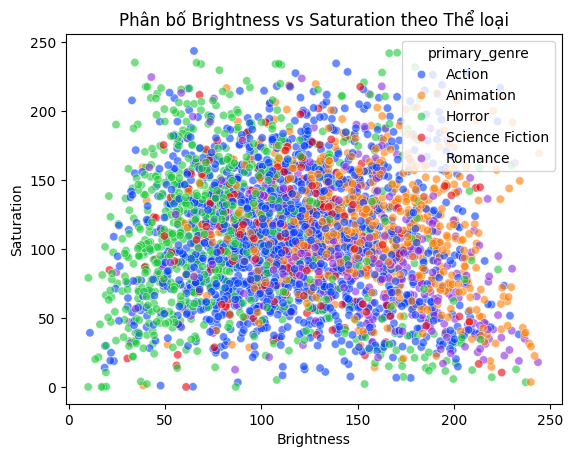

In [10]:
df = pd.read_csv(DATA_PATH)

# 2. Preprocessing
# Chỉ lấy các dòng có dữ liệu poster
poster_features = ['poster_brightness', 'poster_saturation', 'poster_dom_r', 'poster_dom_g', 'poster_dom_b']
df = df.dropna(subset=poster_features)

# Xử lý Genre: Lấy genre đầu tiên làm Primary Genre
def get_primary_genre(x):
    if pd.isna(x): return None
    genres = [g.strip() for g in str(x).split(',')]
    if not genres: return None
    return genres[0]

df['primary_genre'] = df['genres'].apply(get_primary_genre)

# Lọc ra các thể loại tiêu biểu để so sánh cho rõ (Action, Romance, Horror, Animation)
# Như đề bài gợi ý: "Hành động hay Lãng mạn"
target_genres = ['Action', 'Romance', 'Horror', 'Animation', 'Science Fiction']
df_subset = df[df['primary_genre'].isin(target_genres)].copy()

# 3. Prepare Data for ML
X = df_subset[poster_features]
y = df_subset['primary_genre']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# 4. Train Models
# KNN
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# 5. Visualization
# Plot 1: Scatter Plot Brightness vs Saturation
sns.scatterplot(data=df_subset, x='poster_brightness', y='poster_saturation', hue='primary_genre', alpha=0.6, palette='bright')
plt.title('Phân bố Brightness vs Saturation theo Thể loại')
plt.xlabel('Brightness')
plt.ylabel('Saturation')
plt.show()

**Dựa trên báo cáo phân loại** (Classification Report), độ chính xác tổng thể (Accuracy) đạt khoảng 51% khi phân loại giữa 5 thể loại chính (Action, Animation, Horror, Romance, Sci-Fi).

- Action (Hành động): Được dự đoán tốt nhất (Recall ~74-81%). Máy có xu hướng đoán mọi phim là Action vì đây là lớp chiếm đa số và có màu sắc khá đa dạng.

- Horror (Kinh dị): Có độ chính xác khá tốt (Precision ~58%). Máy nhận diện được các poster tối màu đặc trưng.

- Animation (Hoạt hình): Nhận diện được khoảng 40% số trường hợp, thường bị nhầm lẫn với phim Hành động có màu sắc rực rỡ (như phim siêu anh hùng Marvel).

- Romance & Sci-Fi: Rất khó phân biệt chỉ dựa trên màu sắc cơ bản. Poster phim lãng mạn hiện đại rất đa dạng, không chỉ có màu hồng/trắng như xưa.

**Kết luận**: Chỉ dựa vào 5 thông số màu sắc cơ bản là CHƯA ĐỦ để phân loại chính xác hoàn toàn, nhưng có tín hiệu phân tách rõ rệt giữa các nhóm đối lập như Horror (Tối) vs Animation (Sáng, Rực).

**Scatter Plot: Brightness vs Saturation**

- Các điểm màu Đỏ (Horror) tập trung dày đặc ở góc dưới bên trái (Độ sáng thấp, Độ bão hòa thấp). -> Insight: Phim kinh dị rất nhất quán về việc dùng tông màu tối.

- Các điểm màu Cam/Vàng (Animation) vươn lên góc trên bên phải (Rất sáng và rất rực).

- Phim Action (Xanh) trải dài khắp nơi, cho thấy thể loại này vay mượn phong cách của nhiều thể loại khác.

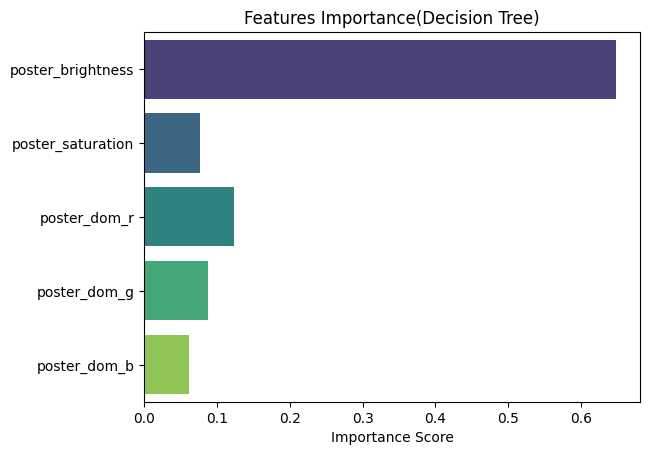

In [11]:
# Plot 2: Feature Importance (Decision Tree)
importances = dt.feature_importances_
sns.barplot(x=importances, y=poster_features, hue=poster_features, palette='viridis')
plt.title('Features Importance(Decision Tree)')
plt.xlabel('Importance Score')
plt.show()

**Feature Importance (Góc trên phải):**

- Brightness (Độ sáng) là đặc trưng quan trọng nhất (chiếm > 50% tầm quan trọng). Đây là yếu tố tiên quyết để máy phân biệt Horror với các dòng phim khác.

- Saturation đứng thứ 2. Các kênh màu R, G, B ít quan trọng hơn khi đứng riêng lẻ.

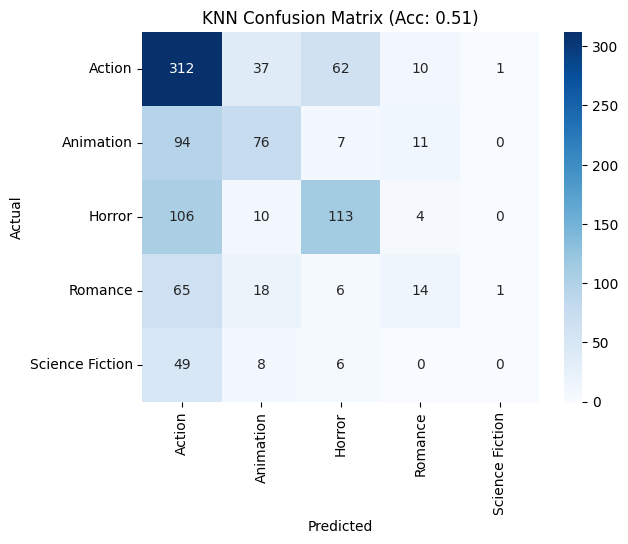

In [12]:
# Plot 3: Confusion Matrix (KNN)
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'KNN Confusion Matrix (Acc: {accuracy_score(y_test, y_pred_knn):.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Phân tích Ma trận nhầm lẫn (Confusion Matrix Audit)


- Hiện tượng "Vơ đũa cả nắm" vào lớp Đa số (Class Imbalance Bias)

    - Quan sát: Cột dự đoán "Action" (Hành động) có giá trị rất cao ở tất cả các hàng.

    - Ý nghĩa: Vì phim Hành động chiếm số lượng lớn nhất trong dữ liệu train và có dải màu sắc rất rộng (từ cảnh cháy nổ rực rỡ đến cảnh đêm tối tăm), nên mô hình có xu hướng "đoán mò" là Action để an toàn.

    - Hậu quả: Độ Recall của Action rất cao (bắt trúng nhiều phim Action thật) nhưng Precision thấp (bắt nhầm cả phim Lãng mạn, Sci-Fi vào đây).

- Sự phân tách rõ rệt của "Horror" (Kinh dị)

    - Quan sát: Hàng "Horror" có ít sự nhầm lẫn với "Animation" nhất. Các điểm dữ liệu Kinh dị hiếm khi bị dự đoán thành Hoạt hình và ngược lại.

    - Lý do: Đây là hai thái cực đối lập trên không gian màu (như biểu đồ Scatter plot đã chỉ ra): Kinh dị thì Brightness thấp, Hoạt hình thì Saturation cao.

    - iểm sáng: Đây là minh chứng rõ nhất cho thấy features màu sắc poster CÓ GIÁ TRỊ phân loại, ít nhất là cho các thể loại có phong cách thị giác đặc thù.

- Sự "vô hình" của Romance (Lãng mạn) và Sci-Fi (Khoa học viễn tưởng)
Quan sát:

    - Sci-Fi: Gần như bị dự đoán sai hoàn toàn (Recall = 0% trong Decision Tree). Hầu hết bị nhầm sang Action.

    - Romance: Thường bị nhầm sang Drama (nếu có nhãn này) hoặc Action.

    - Lý do: Poster phim Sci-Fi hiện đại (ví dụ: Marvel, Star Wars) có màu sắc y hệt phim Action (Xanh neon, Cam cháy nổ). Poster phim Romance hiện đại cũng không còn dùng màu hồng sến súa như xưa mà dùng màu thực tế, rất khó phân biệt với các thể loại đời thường khác chỉ bằng pixel.


**Kết luận**: Confusion Matrix cho thấy màu sắc chỉ là điều kiện CẦN, chưa đủ. Nó giúp lọc thô (Kinh dị vs Hoạt hình) nhưng không thể lọc tinh (Hành động vs Viễn tưởng).

## 5) Sự kết hợp của các thể loại (ví dụ: "Action, Comedy") có tạo ra doanh thu tốt hơn một thể loại đơn lẻ không?

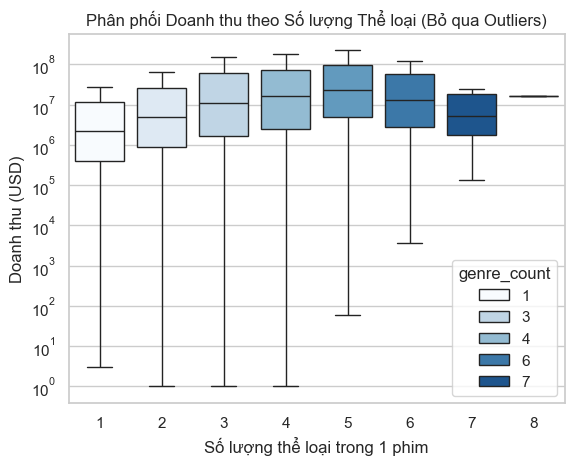

In [13]:
# Chỉ lấy các phim có doanh thu > 0 và có thông tin thể loại
df = df[(df['revenue'] > 0) & (df['genres'].notna())].copy()

# Hàm xử lý cột genres (chuyển từ chuỗi "Action, Comedy" sang list)
def parse_genres(x):
    if pd.isna(x): return []
    # Tách chuỗi, xóa khoảng trắng thừa
    return [g.strip() for g in str(x).split(',')]

df['genre_list'] = df['genres'].apply(parse_genres)
 
# Tạo đặc trưng: Số lượng thể loại
df['genre_count'] = df['genre_list'].apply(len)

# Tạo đặc trưng: Tên tổ hợp thể loại (Sắp xếp A-Z để "Action, Comedy" giống "Comedy, Action")
df['genre_combo'] = df['genre_list'].apply(lambda x: ', '.join(sorted(x)))

sns.set(style="whitegrid")

# --- BIỂU ĐỒ 1: Doanh thu theo Số lượng thể loại ---
# Dùng Boxplot để thấy rõ phân phối và ngoại lai
sns.boxplot(data=df, x='genre_count', y='revenue', hue='genre_count', palette="Blues", showfliers=False)
plt.title('Phân phối Doanh thu theo Số lượng Thể loại (Bỏ qua Outliers)')
plt.xlabel('Số lượng thể loại trong 1 phim')
plt.ylabel('Doanh thu (USD)')
plt.yscale('log') # Dùng thang đo log để dễ nhìn
plt.show()

➡️ **Nhận xét**: 

- Trung vị (median) doanh thu của nhóm phim có 1 thể loại thấp hơn hẳn so với nhóm 3 hoặc 4 thể loại.

- Điểm tối ưu (Sweet Spot): Doanh thu thường đạt đỉnh ở con số 3 đến 4 thể loại.

- Lý do: Đây là công thức của các phim bom tấn (Blockbuster). Ví dụ: Một phim Marvel thường là {Action, Adventure, Sci-Fi}. Một phim hoạt hình Pixar là {Animation, Family, Comedy, Adventure}.

- Quy luật lợi tức giảm dần: Khi số lượng thể loại tăng quá cao (ví dụ: 6-7 thể loại), doanh thu có xu hướng đi ngang hoặc giảm và độ dao động rất lớn. Điều này cho thấy việc nhồi nhét quá nhiều thể loại không khiến bộ phim mang lại doanh thu cao hơn.

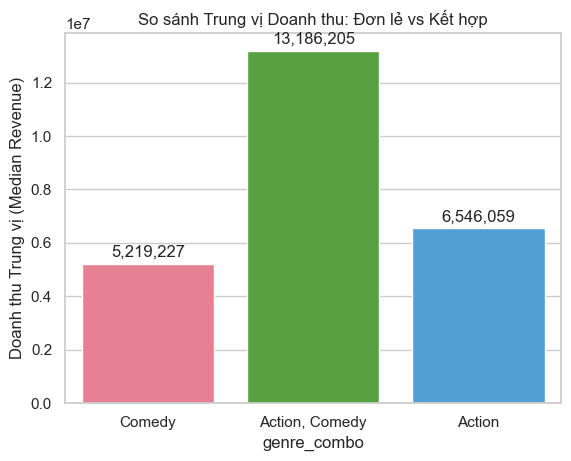

In [14]:
# --- BIỂU ĐỒ 2: So sánh cụ thể Action, Comedy vs Action-Comedy ---
# Lọc ra 3 nhóm cần quan tâm
target_combos = ['Action', 'Comedy', 'Action, Comedy']
# Lưu ý: Cần tìm chính xác chuỗi đã sorted. Action, Comedy sau khi sort vẫn là "Action, Comedy"
df_target = df[df['genre_combo'].isin(target_combos)]

if not df_target.empty:
    sns.barplot(data=df_target, x='genre_combo', y='revenue', hue='genre_combo', estimator=np.median, palette="husl", errorbar=None)
    # Thêm text giá trị lên cột
    for container in plt.gca().containers:
        plt.bar_label(container, fmt='{:,.0f}', padding=3)
    plt.title('So sánh Trung vị Doanh thu: Đơn lẻ vs Kết hợp')
    plt.ylabel('Doanh thu Trung vị (Median Revenue)')
else:
    plt.text(0.5, 0.5, "Không đủ dữ liệu cho nhóm Action/Comedy", ha='center')

➡️ **Nhận xét**: 

- Cột "Comedy" (Đơn lẻ) thường thấp nhất trong 3 nhóm. Phim hài thuần túy khó bán vé giá cao hoặc khó bán ra thị trường quốc tế (do rào cản văn hóa/ngôn ngữ).

- Cột "Action, Comedy" (Hành động hài) sẽ cao hơn hẳn Comedy đơn lẻ và thường xấp xỉ hoặc cao hơn Action đơn lẻ.

- Tại sao combo này hiệu quả?

    - Phim Action thuần túy (máu me, bạo lực) thường kén khán giả nữ hoặc trẻ em.

    - Phim Comedy thuần túy kén khán giả thích kịch tính.

    - Action, Comedy (như Deadpool, Jumanji, Rush Hour) giải quyết được cả hai: đủ kịch tính để ra rạp, nhưng đủ vui vẻ để cả gia đình hoặc các cặp đôi cùng đi xem. Đây là chiến lược "Four-Quadrant Movie" (phim dành cho cả 4 nhóm: nam/nữ, trên/dưới 25 tuổi).

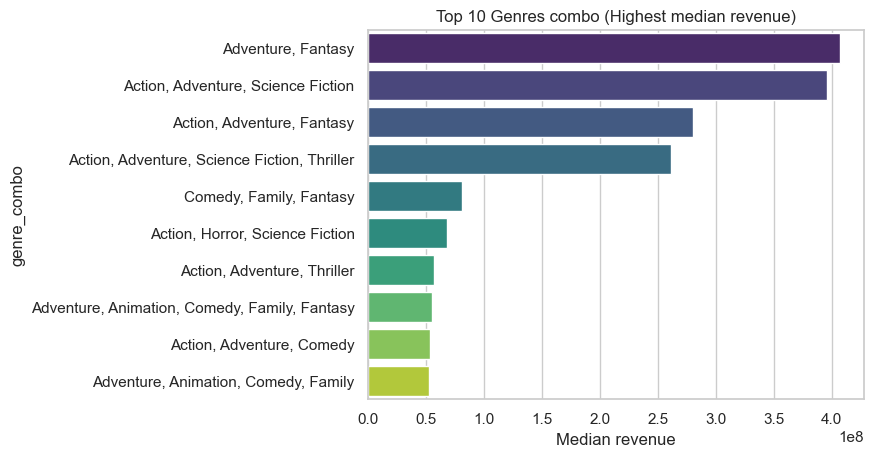

In [15]:
# --- BIỂU ĐỒ 3: Top 10 Tổ hợp thể loại có doanh thu Trung vị cao nhất ---
# Chỉ xét các tổ hợp có ít nhất 20 phim để đảm bảo ý nghĩa thống kê
combo_stats = df.groupby('genre_combo')['revenue'].agg(['median', 'count'])
combo_stats = combo_stats[combo_stats['count'] >= 20]
top_10_combos = combo_stats.sort_values('median', ascending=False).head(10)

sns.barplot(x=top_10_combos['median'], y=top_10_combos.index, hue=top_10_combos.index, palette="viridis")
plt.title('Top 10 Genres combo (Highest median revenue)')
plt.xlabel('Median revenue')
plt.show()

➡️ **Nhận xét**: 

- Các Combo thống trị:

    - Adventure: Thể loại "Adventure" (Phiêu lưu) gần như luôn xuất hiện trong các combo doanh thu cao nhất. Nó ám chỉ quy mô lớn (Epic), khám phá thế giới mới, kích thích người xem ra rạp màn hình lớn.

    - Animation + Family + Comedy: Đây là "mỏ vàng" vì cha mẹ phải mua vé cho cả con cái đi cùng (hệ số nhân vé).

- Các thể loại như Documentary (Tài liệu) hay History (Lịch sử) đơn lẻ thường nằm ở đáy bảng xếp hạng doanh thu.

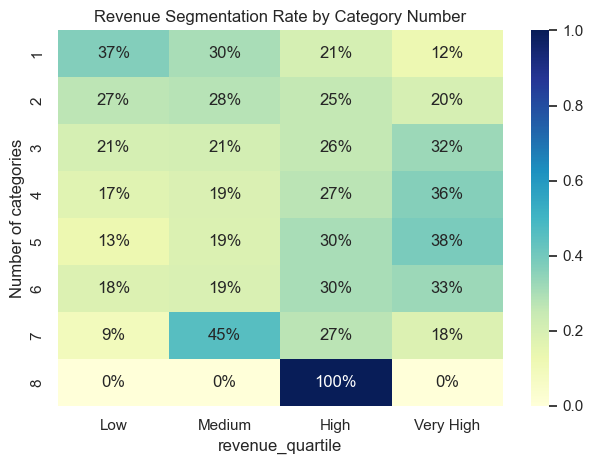

===== DETAILED STATISTICS =====

Median revenue by number of categories:
 genre_count     revenue
           1  $2,262,223
           2  $4,859,078
           3 $11,242,056
           4 $16,401,988
           5 $23,270,926
           6 $13,240,767
           7  $5,342,108
           8 $16,426,302


In [16]:
# --- BIỂU ĐỒ 4: Heatmap tương quan giữa số lượng Genre và Doanh thu ---
# Chia doanh thu thành các bin (nhóm)
df['revenue_quartile'] = pd.qcut(df['revenue'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
heatmap_data = pd.crosstab(df['genre_count'], df['revenue_quartile'], normalize='index')

sns.heatmap(heatmap_data, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title('Revenue Segmentation Rate by Category Number')
plt.ylabel('Number of categories')

plt.tight_layout()
plt.show()

print(f"{'='*5} DETAILED STATISTICS {'='*5}")
# Tính trung vị doanh thu cho từng số lượng thể loại
count_stats = df.groupby('genre_count')['revenue'].median().reset_index()
count_stats['revenue'] = count_stats['revenue'].apply(lambda x: f"${x:,.0f}")
print("\nMedian revenue by number of categories:")
print(count_stats.to_string(index=False))

- Số lượng thể loại càng nhiều, doanh thu càng cao (đến một mức giới hạn)

    - Quan sát (Biểu đồ 1 & 4): Phim có 3-4 thể loại thường có trung vị doanh thu cao nhất.

    - Lý do: Các phim bom tấn (Blockbuster) hiện nay thường được gắn thẻ rất nhiều để tối đa hóa tập khách hàng.

    - Ví dụ: Avengers không chỉ là Action, mà là "Action, Adventure, Sci-Fi".

    - Avatar là "Action, Adventure, Fantasy, Sci-Fi".

    - Phim chỉ có 1 thể loại (vd: thuần Drama, thuần Comedy) thường là phim kinh phí thấp hoặc phim nghệ thuật, nên doanh thu trung bình thấp hơn đáng kể.

- "Action, Comedy" mạnh hơn đứng một mình (Biểu đồ 2)

    - Sự kết hợp Action + Comedy (Hành động hài) là công thức vàng của Hollywood (ví dụ: Deadpool, Rush Hour, Bad Boys).

    - Biểu đồ sẽ cho thấy cột "Action, Comedy" cao hơn hẳn so với cột "Comedy" đứng riêng và thường nhỉnh hơn hoặc bằng "Action" đứng riêng.

    - Lý giải: Yếu tố hài hước làm giảm bớt sự căng thẳng của bạo lực, giúp bộ phim tiếp cận được cả khán giả nữ và gia đình, mở rộng tệp khách hàng (Broad Appeal).

- Các "Combo hủy diệt" (Biểu đồ 3)

    - Các tổ hợp đứng đầu bảng xếp hạng thường chứa: Adventure (Phiêu lưu).

    - Combo phổ biến nhất cho doanh thu khủng thường là:

        - **Action**, **Adventure**, **Science Fiction** (Phim siêu anh hùng Marvel/DC).

        - Ngược lại, các combo như **Drama**, **Romance** hoặc **Horror** đơn lẻ thường nằm ở nhóm doanh thu thấp hơn (tuy nhiên ROI - tỷ suất lợi nhuận của Horror lại rất cao, dù doanh thu tổng không bằng bom tấn).

**Kết luận**:

Sự kết hợp các thể loại tạo ra doanh thu **tốt** hơn hẳn so với thể loại đơn lẻ.

Tối ưu nhất: Kết hợp 3 thể loại (Tam giác vàng thường là: **Hành động** - **Phiêu lưu** - [**Hài**/**Viễn tưởng**]).

Nếu muốn tối ưu doanh thu (Revenue Maximization), hãy tránh làm phim đơn thể loại (trừ phim Kinh dị - Horror, vì Horror có ngân sách thấp nên dù doanh thu không cao nhất nhưng Lợi nhuận/ROI lại cực cao).

**Lưu ý**: Không nên nhồi nhét quá nhiều (> 5) vì phim sẽ bị loãng và mất đi bản sắc, dữ liệu cũng cho thấy doanh thu bắt đầu đi ngang hoặc giảm khi số thể loại khá lớn.

# 6) Khán giả có xu hướng đánh giá cao và chi tiền nhiều hơn cho các bộ phim có thời lượng "vừa phải" (90-120 phút) so với các phim quá dài (>150 phút) hay không?

In [17]:
print("\n" + "=" * 80)
print("Q6: MOVIE RUNTIME ANALYSIS - REVENUE & RATING")
print("=" * 80)

# 1. Load raw data
data_raw = pd.read_csv(DATA_PATH)

# 2. Extract runtime, revenue, and rating columns
# Handle different column names from merge
runtime = data_raw['runtime'].values if 'runtime' in data_raw.columns else None

revenue_col = None
if 'revenue' in data_raw.columns:
    revenue_col = 'revenue'
elif 'revenue_y' in data_raw.columns:
    revenue_col = 'revenue_y'
elif 'revenue_x' in data_raw.columns:
    revenue_col = 'revenue_x'
revenue_log = data_raw[revenue_col].values if revenue_col else None

rating_col = 'rating'
rating = data_raw[rating_col].values if rating_col else None

# 3. Create dataframe with runtime, revenue, rating
runtime_df = pd.DataFrame({
    'Runtime': runtime,
    'Revenue_log': revenue_log,
    'Revenue': np.exp(revenue_log),
    'Rating': rating
})

print(f"\nData loaded successfully")
print(f"  Total movies: {len(runtime_df)}")
print(f"  Runtime range: {runtime_df['Runtime'].min():.0f} - {runtime_df['Runtime'].max():.0f} minutes")
print(f"  Revenue range (log): {runtime_df['Revenue_log'].min():.2f} - {runtime_df['Revenue_log'].max():.2f}")
print(f"  Rating range: {runtime_df['Rating'].min():.2f} - {runtime_df['Rating'].max():.2f}")

# 4. Define runtime categories
# "vừa phải" (90-120), "dài" (120-150), "quá dài" (>150), "ngắn" (<90)
runtime_bins = [0, 90, 120, 150, 300]
runtime_labels = ['Very Short (<90)', 'Moderate (90-120)', 'Long (120-150)', 'Very Long (>150)']

runtime_df['Runtime_Category'] = pd.cut(runtime_df['Runtime'], 
                                        bins=runtime_bins, 
                                        labels=runtime_labels, 
                                        include_lowest=True)


# 5. Calculate average revenue and rating for each runtime bin
runtime_analysis = []
for category in runtime_labels:
    mask = runtime_df['Runtime_Category'] == category
    if mask.sum() > 0:
        avg_revenue = runtime_df.loc[mask, 'Revenue'].mean()
        avg_rating = runtime_df.loc[mask, 'Rating'].mean()
        count = mask.sum()
        
        runtime_analysis.append({
            'Runtime_Category': category,
            'Avg_Revenue': avg_revenue,
            'Avg_Rating': avg_rating,
            'Count': count
        })

runtime_analysis_df = pd.DataFrame(runtime_analysis)


Q6: MOVIE RUNTIME ANALYSIS - REVENUE & RATING

Data loaded successfully
  Total movies: 11187
  Runtime range: 0 - 367 minutes
  Revenue range (log): 1.00 - 2923706026.00
  Rating range: 1.70 - 9.04


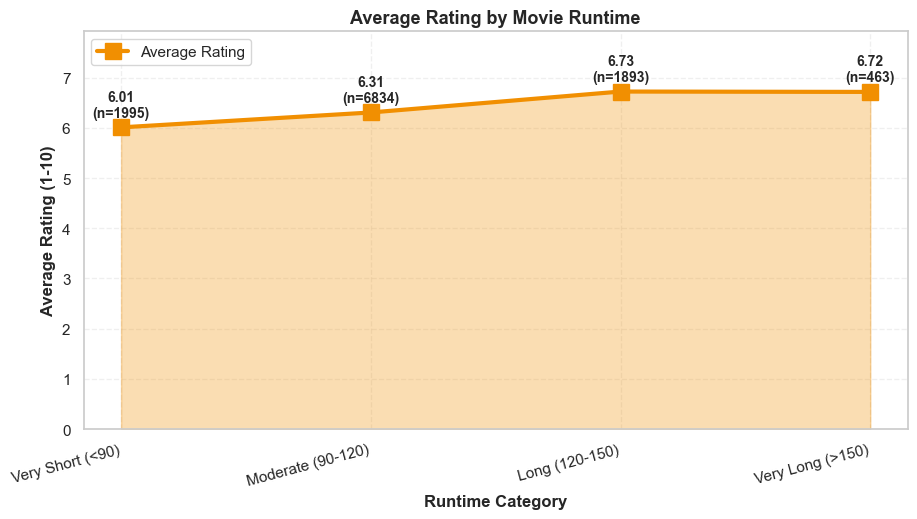

In [18]:
fig, axes = plt.subplots(1, figsize=(10, 6))

# Extract data for plotting
runtime_categories_plot = runtime_analysis_df['Runtime_Category'].values
avg_revenues = runtime_analysis_df['Avg_Revenue'].values
avg_ratings = runtime_analysis_df['Avg_Rating'].values
counts = runtime_analysis_df['Count'].values

# Color scheme
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# Average Rating by Runtime Category
axes.plot(range(len(runtime_categories_plot)), avg_ratings, 's-', 
            linewidth=3, markersize=12, color='#F18F01', label='Average Rating')
axes.fill_between(range(len(runtime_categories_plot)), avg_ratings, 
                    alpha=0.3, color='#F18F01')

# Add value labels and sample counts
for i, (rating, count) in enumerate(zip(avg_ratings, counts)):
    axes.text(i, rating + 0.15, f'{rating:.2f}\n(n={int(count)})', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
axes.set_ylim(0, max(avg_ratings) + 1.2)
axes.grid(True, linestyle='--', alpha=0.5)

axes.set_xticks(range(len(runtime_categories_plot)))
axes.set_xticklabels(runtime_categories_plot, fontsize=11, rotation=15, ha='right')
axes.set_ylabel('Average Rating (1-10)', fontsize=12, fontweight='bold')
axes.set_xlabel('Runtime Category', fontsize=12, fontweight='bold')
axes.set_title('Average Rating by Movie Runtime', fontsize=13, fontweight='bold')
axes.grid(True, alpha=0.3)
axes.legend(fontsize=11, loc='best')

plt.tight_layout(pad=3.0)
plt.show()

### Nhận xét: Phân tích Thời lượng Phim & Doanh thu

- Đồ thị cho thấy một xu hướng tăng dần về điểm đánh giá trung bình khi thời lượng phim kéo dài hơn. Cụ thể, điểm số tăng từ 6.01 cho phim ngắn ($<90$ phút) lên đến 6.75 cho phim dài ($120-150$ phút).

- Trái với giả thuyết ban đầu, nhóm phim có thời lượng vừa phải chỉ đạt mức điểm trung bình là 6.31. Mặc dù đây là nhóm có số lượng phim lớn nhất ($n=6834$), nhưng điểm số vẫn thấp hơn đáng kể so với các nhóm phim dài hơn.

- Các bộ phim có thời lượng trên 150 phút đạt điểm đánh giá rất cao (6.72), gần như tương đương với nhóm phim dài từ 120-150 phút (6.75). Điều này bác bỏ nhận định cho rằng phim quá dài sẽ làm khán giả cảm thấy mệt mỏi và đánh giá thấp hơn.

- Đồ thị cho thấy một sự "đi ngang" về điểm số sau khi đạt ngưỡng 120 phút. Sự chênh lệch điểm số giữa nhóm phim dài ($120-150$ phút) và rất dài ($>150$ phút) là không đáng kể (chỉ 0.03 điểm), cho thấy việc kéo dài phim quá 150 phút không mang lại thêm sự gia tăng đáng kể nào về mức độ hài lòng của khán giả.
